<a href="https://colab.research.google.com/github/gibranfp/CursoAprendizajeAutomatizado/blob/2023-2/notebooks/2c_reglin_descenso_gradiente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión lineal mediante descenso por gradiente
En esta libreta programaremos y evaluaremos el algoritmo de descenso por gradiente para regresión lineal.

In [1]:
import numpy as np
np.random.seed(42) # por reproducibilidad

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error as ecm
from sklearn.model_selection import train_test_split

## Conjunto de datos
Posteriormente cargamos los datos de GPAs de alumnos de licenciatura (fuente: http://onlinestatbook.com/2/case_studies/sat.html). Usamos sólo el atributo Computer Science GPA (columna `comp_GPA`) como regresor para el University GPA (columna `univ_GPA`).

In [2]:
sat = pd.read_csv('http://onlinestatbook.com/2/case_studies/data/sat.txt', sep=' ')

X = sat.comp_GPA.to_numpy()[:, np.newaxis]
y = sat.univ_GPA.to_numpy()[:, np.newaxis]

ones = np.ones((X.shape[0], 1))
X = np.concatenate((ones, X), axis = 1)

Dividimos  aleatoriamente el conjunto de datos en 80% para entrenamiento y 20% para validación. Para eso usaremos la funcion `train_test_split` de scikit-learn.

In [3]:
X_ent, X_valid, y_ent, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

X_rango = np.arange(2.0, 4.0, 0.01)[:, np.newaxis] 
ones_rango = np.ones((X_rango.shape[0], 1))
X_rango = np.concatenate((ones_rango, X_rango), axis = 1).T

## Descenso por gradiente
Vamos a entrenar un modelo de regresión lineal usando descenso por gradiente. En particular, buscaremos minimizar la suma de errores cuadráticos, la cual definimos de la siguiente manera:
$$
E(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{2} \sum_{i = 1} ^n \left(\hat{y^{(i)}} - y^{(i)}\right)^2
$$

El gradiente de esta función de pérdida respecto a los parámetros $\boldsymbol{\theta} \in \mathbb{R}^d$ está dado por

$$
\nabla E(\mathbf{y}, \hat{\mathbf{y}}) = \left[\frac{\partial E(\mathbf{y}, \hat{\mathbf{y}})}{\partial \theta_0}, \frac{\partial E(\mathbf{y}, \hat{\mathbf{y}})}{\partial \theta_1}, \cdots, \frac{\partial E(\mathbf{y}, \hat{\mathbf{y}})}{\partial \theta_d}\right]
$$

donde

$$
\frac{\partial E(\mathbf{y}, \hat{\mathbf{y}})}{\partial \theta_j} = \sum_{i=1}^n \left[ \left(\hat{y^{(i)}} - y^{(i)}\right) \cdot x_j^{(i)} \right]
$$

In [4]:
def gradiente(X, y, y_predicha):
  return X.T @ (y_predicha - y)

El algoritmo del descenso por gradiente quedaría como sigue:

In [5]:
def descenso_gradiente(X, y, n_iter = 10, tasa = 0.001):
  hist_error = np.zeros(n_iter)
  
  # Inicializamos parámetro con número aleatorio
  param = np.random.rand(X.shape[1], 1)

  for it in range(n_iter):
    # Obtenemos predicciones con parámetro actual
    y_predicha =  X @ param

    hist_error[it] = ecm(y, y_predicha)

    # Actualizamos parámetro
    param = param - tasa * gradiente(X, y, y_predicha)

  return param, hist_error

## Entrenamiento
Entrenamos nuestro modelo de regresión lineal con este algoritmo por 1000 iteraciones con una tasa de aprendizaje de 0.001:

In [6]:
n_iter = 1000
param_dg, errores= descenso_gradiente(X_ent, 
                                      y_ent, 
                                      n_iter = n_iter, 
                                      tasa = 0.001)

Graficamos el error cuadrático medio en cada iteración:

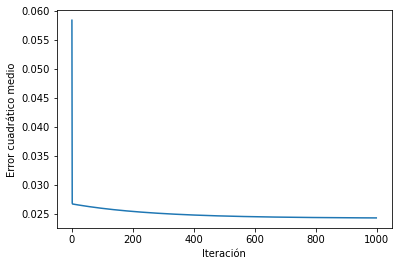

In [7]:
plt.plot(np.array(range(n_iter)), errores)
plt.xlabel(u'Iteración')
plt.ylabel(u'Error cuadrático medio')
plt.show()

Comparamos los parámetros encontrados por mínimos cuadrados y usando el algoritmo del descenso por gradiente

In [8]:
param_mc = np.linalg.inv(X_ent.T @ X_ent) @ (X_ent.T @ y_ent)

print(f'MC = {param_mc.T}')
print(f'DG = {param_dg.T}')

MC = [[0.67739565 0.80044273]]
DG = [[0.62816373 0.81577453]]


Visualizamos las rectas con ambas soluciones

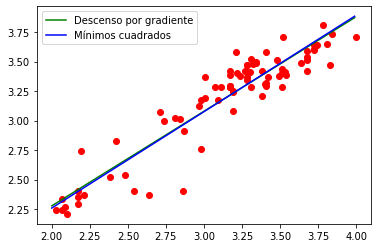

In [9]:
y_rango_dg = X_rango.T @ param_dg
y_rango_mc = X_rango.T @ param_mc

plt.plot(X_ent[:, 1], y_ent[:, 0], 'ro')
plt.plot(X_rango.T[:, 1], y_rango_mc[:, 0], 'g', label='Descenso por gradiente')
plt.plot(X_rango.T[:, 1], y_rango_dg[:, 0], 'b', label='Mínimos cuadrados')
plt.legend()
plt.show()

## Ejercicio
+ Programa y evalúa el algoritmo del descenso por gradiente para regresión lineal que minimice la siguiente función de error:

$$
E(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{2\cdot n} \sum_{i = 1} ^n \left(\hat{y}^{(i)} - y^{(i)}\right)^2
$$